# Debugging AR DEM Distribution

Trying to figure out why the AR DEM is so much worse looking compared to when I ran the inversion previously

In [1]:
import pathlib

import astropy.units as u
import astropy.time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import aiapy
from sunpy.net import Fido, attrs as a
import sunpy.map
from astropy.visualization import quantity_support,ImageNormalize,LogStretch,AsinhStretch
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame

from mocksipipeline.physics.dem.data_prep import DataQuery,DataPrep
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.net import XRTSynopticClient, FilterWheel1, FilterWheel2

In [2]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [3]:
data_dir = pathlib.Path('../pipeline-runs/ar-test')
aia_maps = sunpy.map.Map(list((data_dir / 'AIA').glob('*.fits')))
xrt_maps = sunpy.map.Map(list((data_dir / 'XRT').glob('*.fits')))
#ar_time = astropy.time.Time('2020-11-09 18:00:00')
ar_time = aia_maps[0].date

In [4]:
correction_table = aiapy.calibrate.util.get_correction_table() 
pointing_table = aiapy.calibrate.util.get_pointing_table(ar_time-6*u.h, ar_time+6*u.h)
error_table = aiapy.calibrate.util.get_error_table(
    error_table='/Users/wtbarnes/ssw/sdo/aia/response/aia_V3_error_table.txt'
)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [5]:
#dq = DataQuery(data_dir,
#               ar_time,
#               aia_error_table=error_table,
#               aia_correction_table=correction_table,
#               aia_pointing_table=pointing_table,
#               temperature_bin_edges=temperature_bin_edges)
dq = DataPrep(map_list=aia_maps+[xrt_maps,],
              aia_error_table=error_table,
              aia_correction_table=correction_table,
              aia_pointing_table=pointing_table,
              temperature_bin_edges=temperature_bin_edges)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units

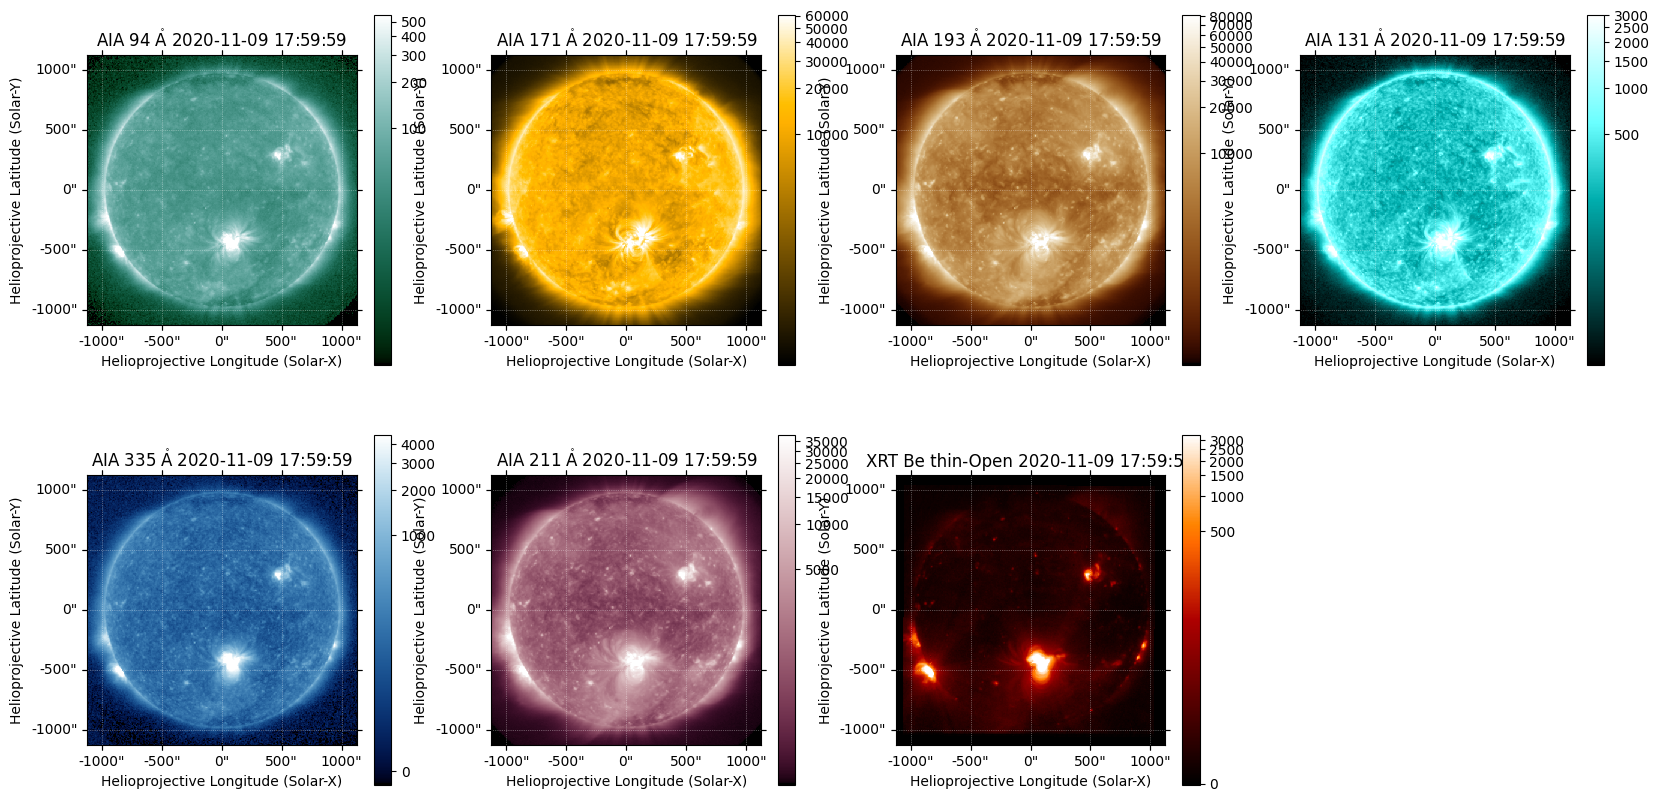

In [6]:
fig = plt.figure(figsize=(20,10))
for i,k in enumerate(dq.collection):
    ax = fig.add_subplot(2,4,i+1,projection=dq.collection[k])
    m = sunpy.map.Map(dq.collection[k].data, dq.collection[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    im = m.plot(axes=ax, clip_interval=(1,99.7)*u.percent)
    fig.colorbar(im)

In [7]:
kernels = dq.response_kernels

(1e-27, 1e-22)

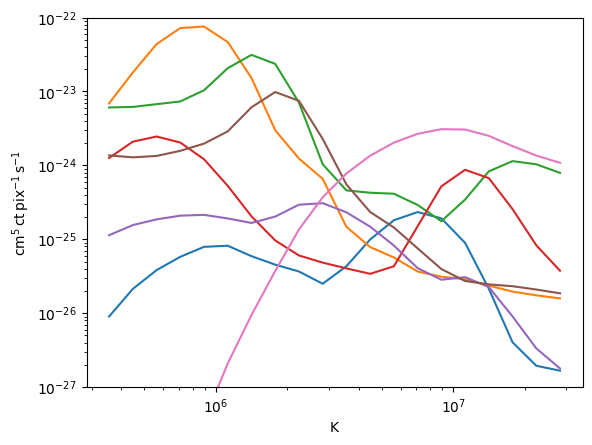

In [8]:
with quantity_support():
    for k in kernels:
        plt.plot(dq.temperature_bin_centers, kernels[k], label=k)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-27, 1e-22)

In [9]:
dem_cube = dq.run()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: RuntimeWarning: divide by zero encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  0%|                                                                                                                                   | 0.00/2.02k [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: Run

In [10]:
(dem_cube.data < 0.0).any()
np.where(dem_cube.data < 0.0)[0].shape

(0,)

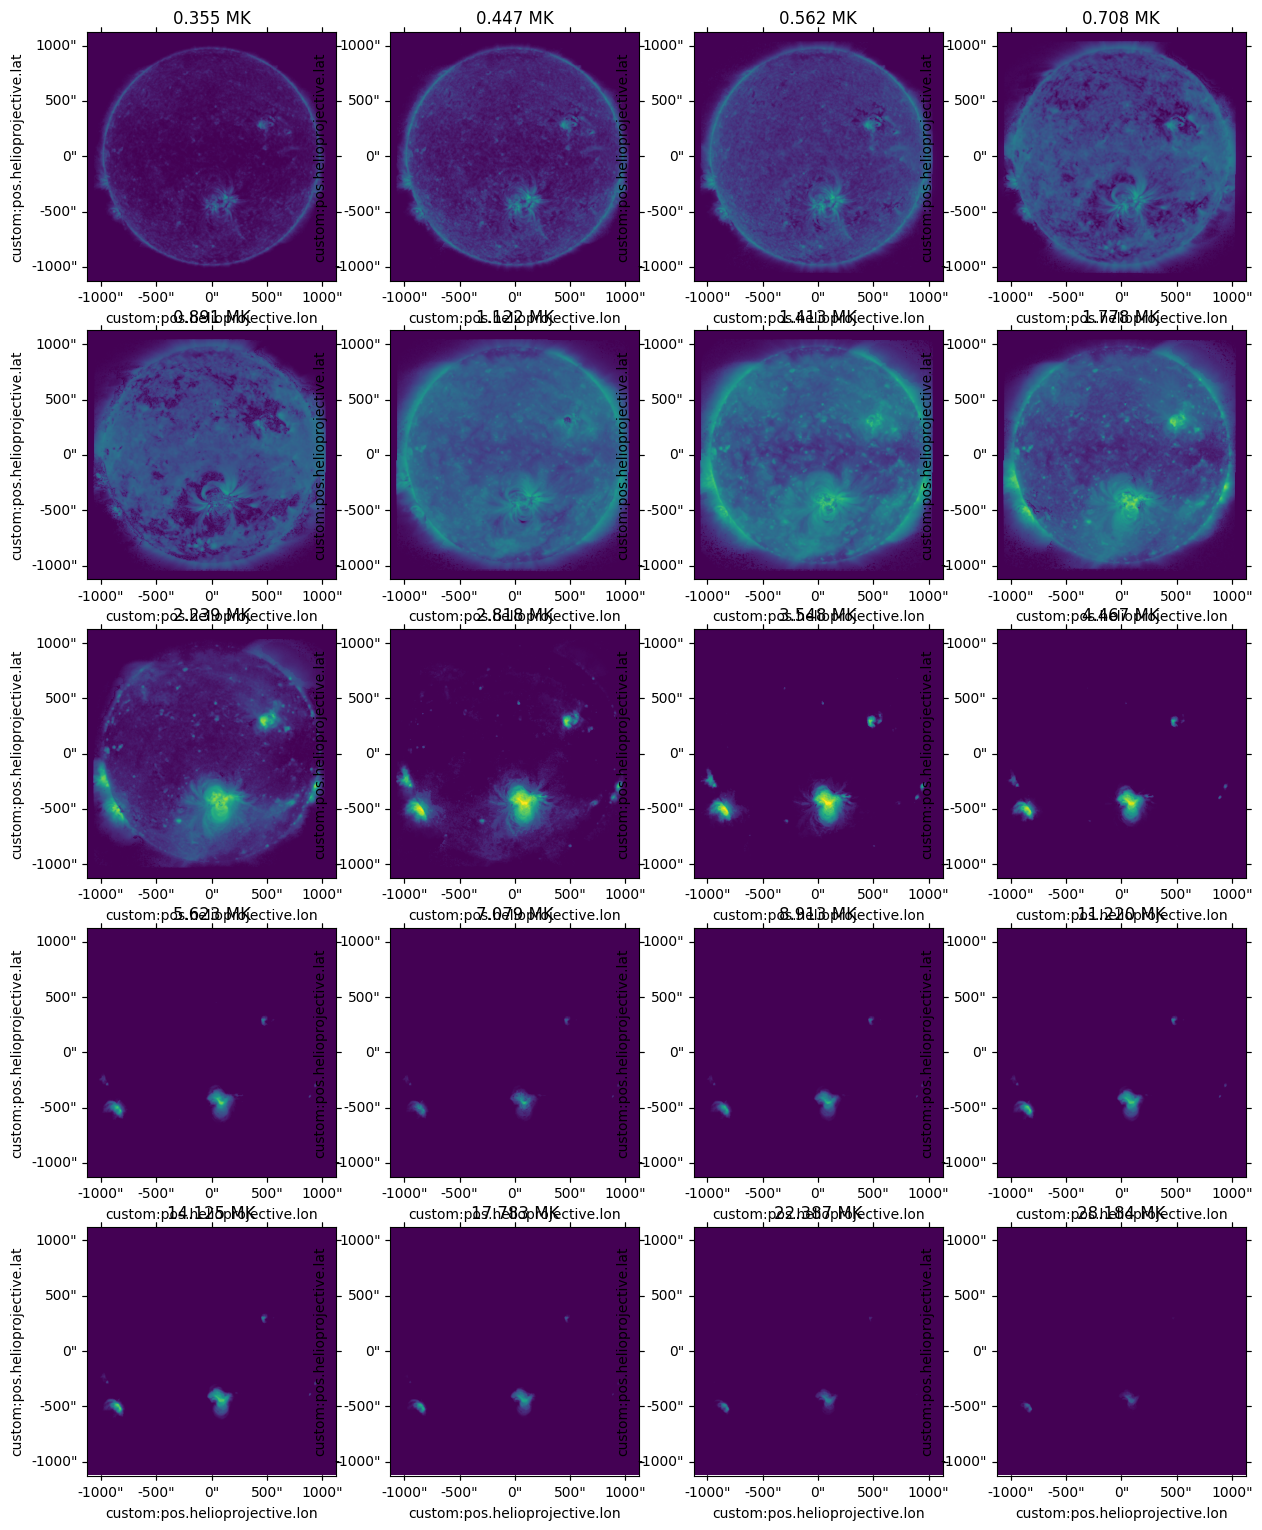

In [11]:
fig = plt.figure(figsize=(15,15*5/4))
for i,cube in enumerate(dem_cube):
    ax = fig.add_subplot(5,4,i+1,projection=cube)
    ax.set_title(f'{dq.temperature_bin_centers[i].to("MK"):.3f}')
    cube.plot(axes=ax,norm=ImageNormalize(vmax=1e28,vmin=1e24,stretch=LogStretch()))

In [12]:
flare_loc = SkyCoord(Tx=50*u.arcsec, Ty=-450*u.arcsec, frame=wcs_to_celestial_frame(dq.celestial_wcs))

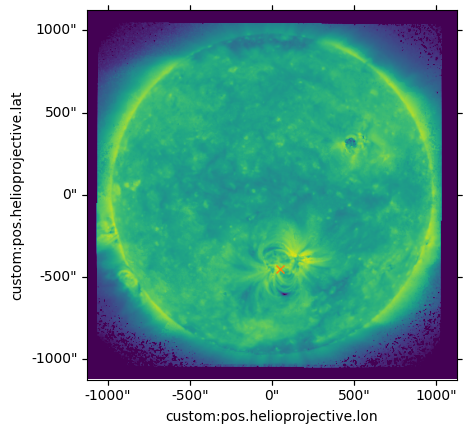

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection=dem_cube[10].wcs)
dem_cube[5].plot(norm=ImageNormalize(vmax=1e27,vmin=1e24,stretch=LogStretch()),axes=ax)
ax.plot_coord(flare_loc,marker='x',color='C1',ls='')

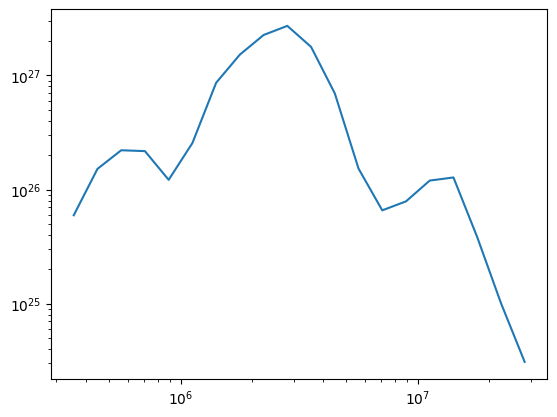

In [17]:
ir,ic = dem_cube[0].wcs.world_to_array_index(flare_loc)
plt.plot(dq.temperature_bin_centers,dem_cube.data[:,ir,ic])
plt.xscale('log')
plt.yscale('log')

In [21]:
spec_model = SpectralModel()

In [22]:
spec_cube = spec_model.run(dem_cube, dq.celestial_wcs)

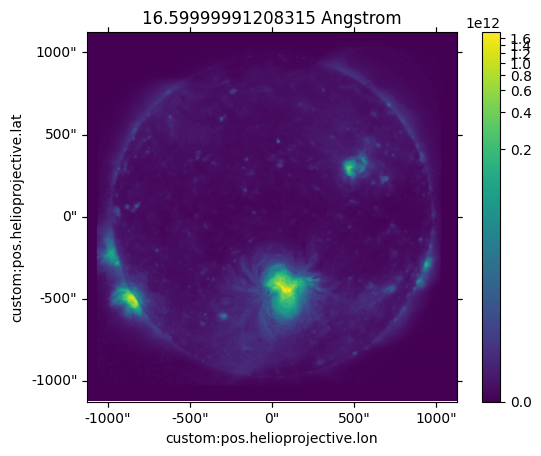

In [25]:
i_wave = 300
spec_cube[i_wave].plot(norm=ImageNormalize(stretch=LogStretch()))
plt.title(spec_cube.axis_world_coords(0)[0][i_wave].to('Angstrom'))
plt.colorbar()

## DEM Sandbox

In [16]:
import sunkit_dem

In [19]:
sl_index = np.s_[225:375,:150]

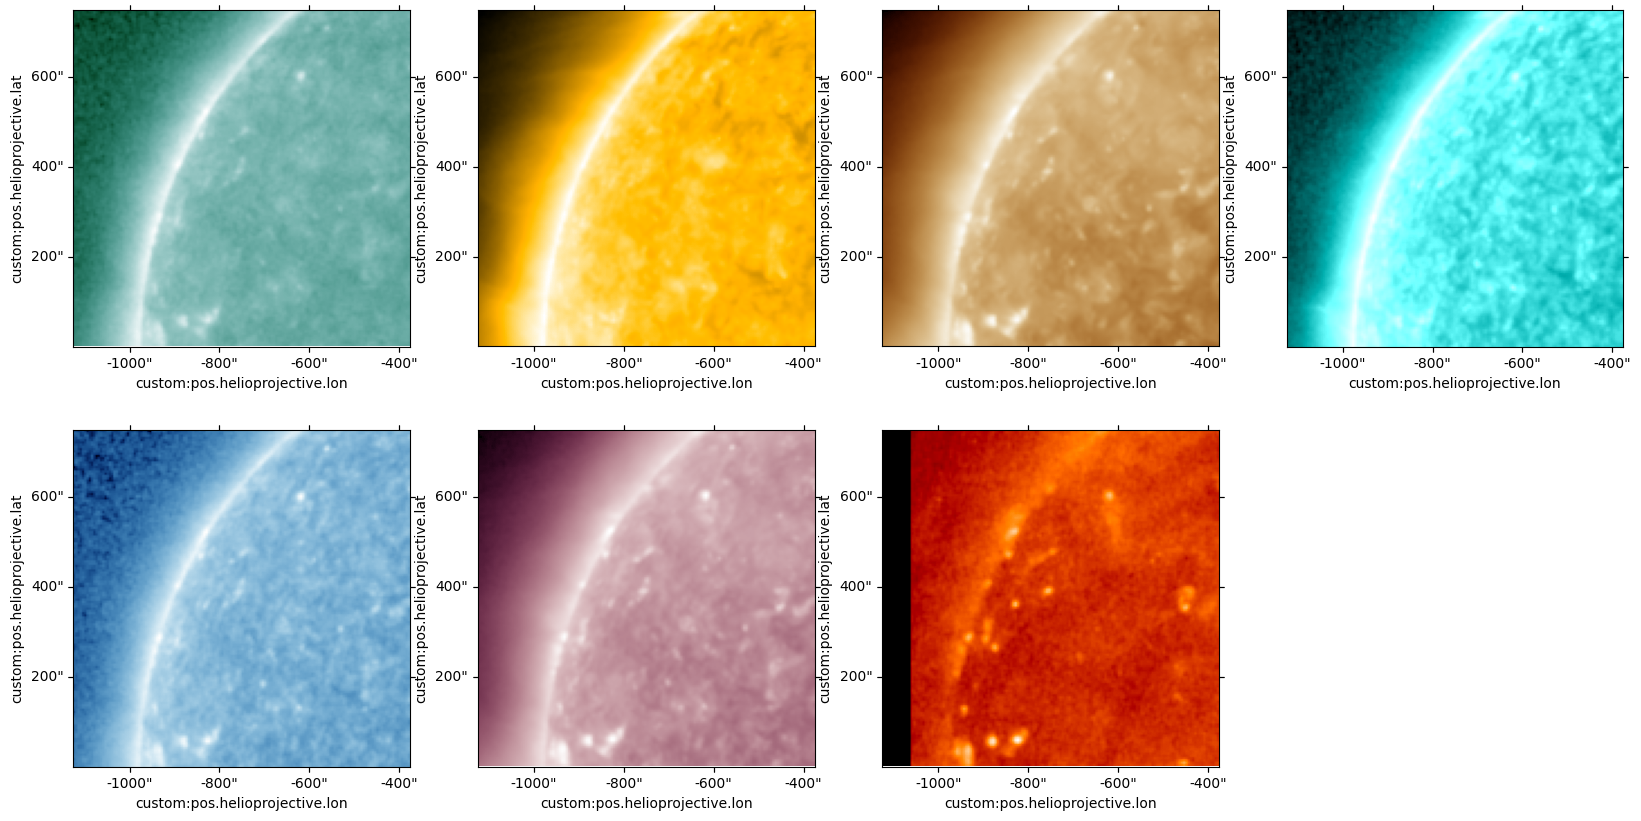

In [20]:
fig = plt.figure(figsize=(20,10))
for i,k in enumerate(dq.collection):
    m = sunpy.map.Map(dq.collection[k].data, dq.collection[k].meta)
    if 'AIA' in m.instrument:
        m.plot_settings["cmap"] = f'sdo{m.plot_settings["cmap"]}'
    cube = dq.collection[k][sl_index]
    ax = fig.add_subplot(2,4,i+1,projection=cube)
    cube.plot(axes=ax,norm=m.plot_settings['norm'],
              cmap=m.plot_settings['cmap'])

In [21]:
dem_model = sunkit_dem.Model(
    dq.collection[sl_index],
    dq.response_kernels,
    dq.temperature_bin_edges,
    model='hk12',
)

In [49]:
dem_test = dem_model.fit(
    alpha=1.5,
    increase_alpha=1.2,
    max_iterations=100,
    use_em_loci=True,
    emd_int=True,
)

  0%|                                                                                                                                     | 0.00/225 [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: RuntimeWarning: divide by zero encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/demregpy/demmap.py:199: Run

In [50]:
(dem_test['em'].data < 0.0).any()
np.where(dem_test['em'].data < 0.0)[0].shape

(17505,)

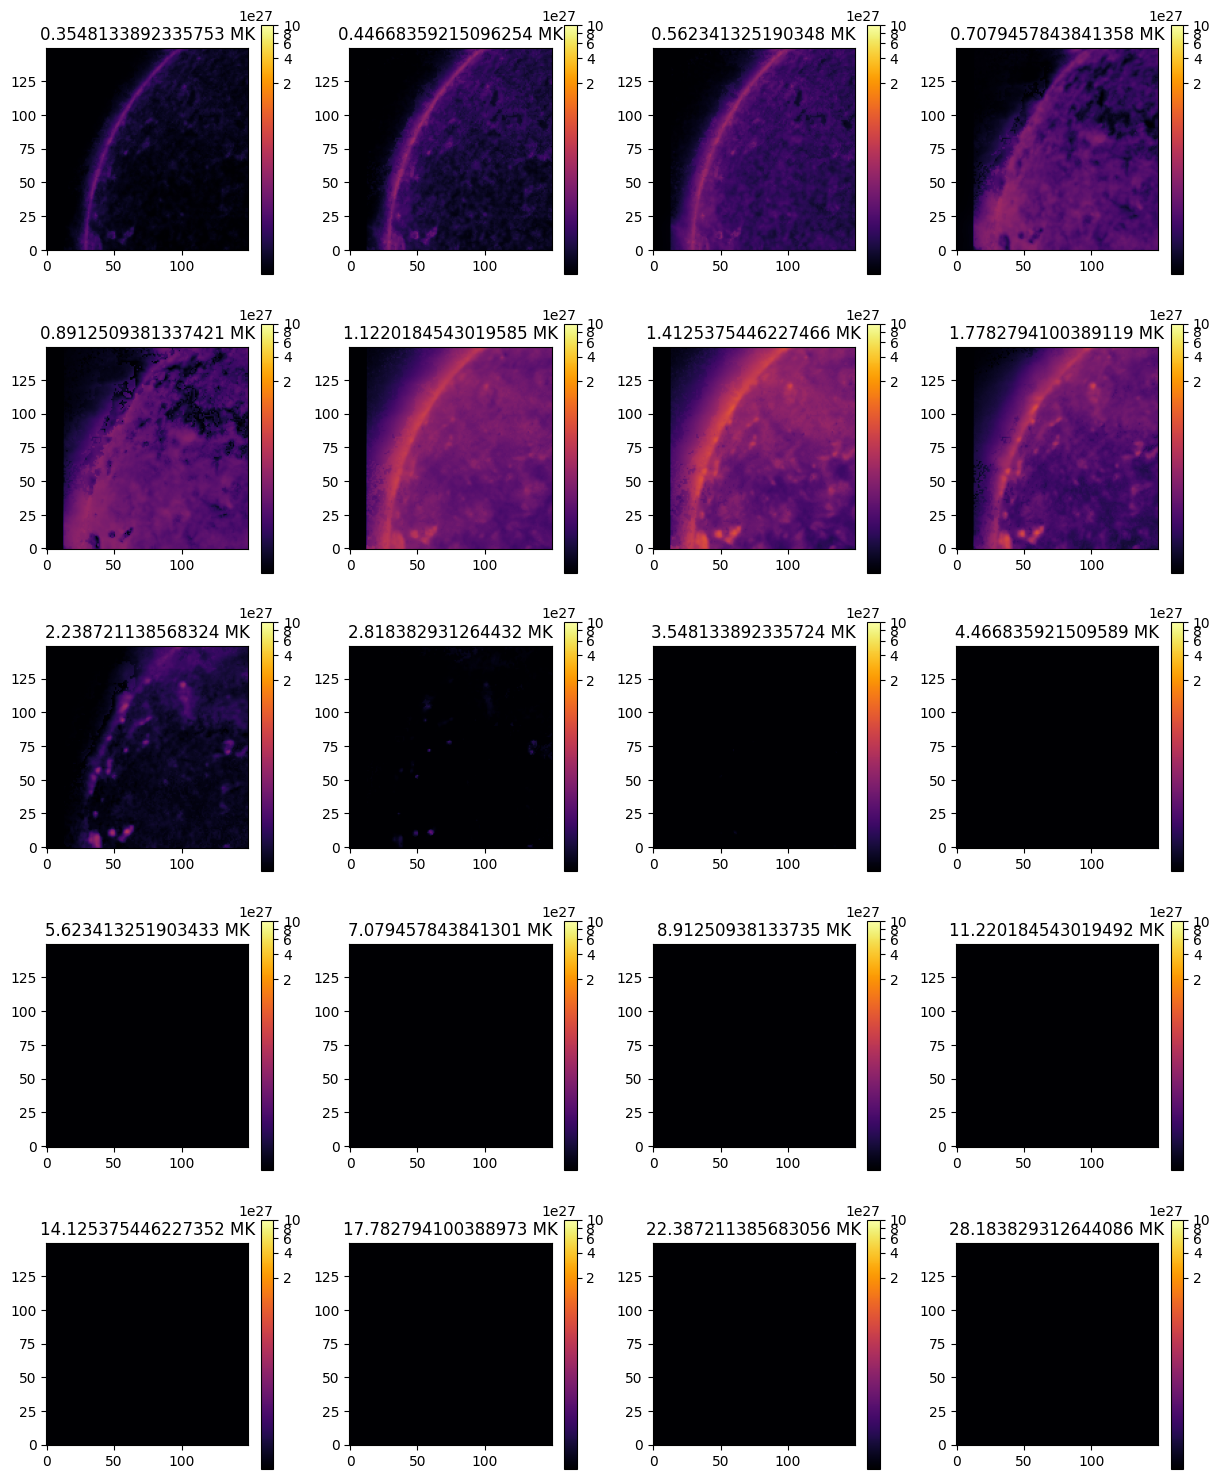

In [51]:
fig = plt.figure(figsize=(15,15*5/4))
for i,cube in enumerate(dem_test['em']):
    ax = fig.add_subplot(5,4,i+1)
    ax.set_title(dem_model.temperature_bin_centers[i].to('MK'))
    norm = ImageNormalize(vmax=1e28,vmin=1e24,stretch=LogStretch())
    #norm = matplotlib.colors.LogNorm(vmin=1e24, vmax=1e28)
    im = ax.imshow(cube.data,
                   origin='lower',
                   cmap='inferno',
                   norm=norm)
    fig.colorbar(im)

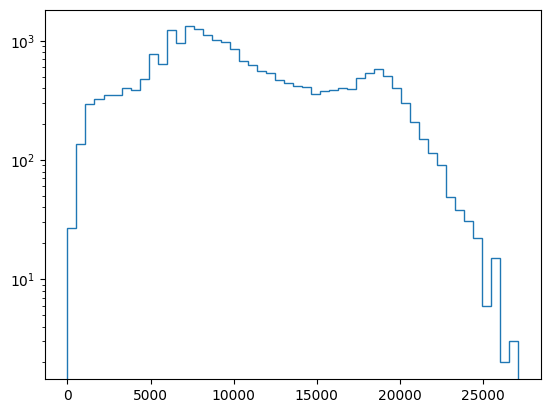

In [33]:
plt.hist(dem_test['chi_squared'].data.flatten(), log=True, bins='fd',histtype='step');

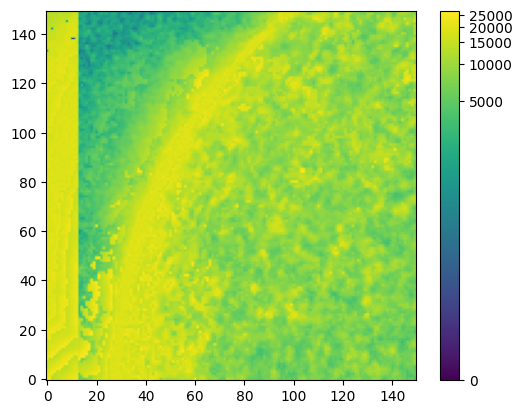

In [34]:
plt.imshow(dem_test['chi_squared'].data,origin='lower',norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()

In [35]:
test_point = SkyCoord(Tx=100*u.arcsec, Ty=-500*u.arcsec, frame=wcs_to_celestial_frame(dq.celestial_wcs))

In [36]:
px,py = dq.collection['94.0 Angstrom'][sl_index].wcs.world_to_pixel(test_point)

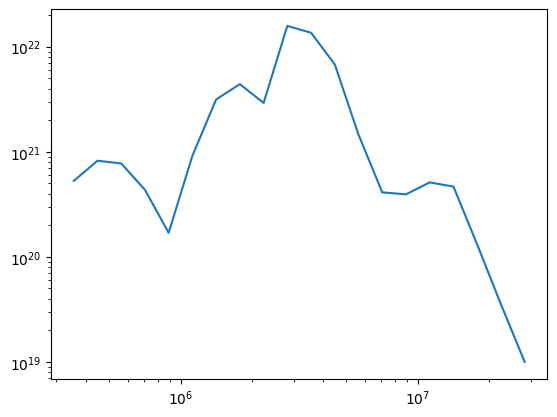

In [64]:
plt.errorbar(dq.temperature_bin_centers,
             dem_test['dem'].data[:,int(py),int(px)],
             yerr=dem_test['dem'].uncertainty.array[:,int(py),int(px)],)
#plt.plot(dq.temperature_bin_centers, dem_test['em'].data.sum(axis=(1,2)))
plt.yscale('log')
plt.xscale('log')